In [1]:
%matplotlib notebook

from Inn2 import RadynversionNet, AtmosData, RadynversionTrainer
import loss as Loss
import pickle
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import torch
import torch.optim
import torch.utils.data
from torch.distributions.multivariate_normal import MultivariateNormal

from time import time

dev = 'cuda' if torch.cuda.is_available() else 'cpu'
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
# dataLocation1 = '/local0/scratch/HAlphaGridExportStatic/DoublePicoMegaPickle50.pickle'
# dataLocation3 = '/local0/scratch/HAlphaGridExportStatic/MiniBalancedTraining.pickle'
# dataLocation2 = '/local0/scratch/HAlphaGridExportStatic/TestPickle50.pickle'
# dataLocation = '/local0/scratch/Chris/DoublePicoMegaPickle50.pickle'
# dataLocation = 'G:\\DoublePicoMegaPickle.pickle'
balancedData = 'MiniBalancedTraining.pickle'

data = AtmosData([balancedData], resampleWl=30)
data.split_data_and_init_loaders(100)


In [3]:
inRepr = [('!!PAD',), ('ne', data.ne.shape[1]), ('temperature', data.temperature.shape[1]), ('vel', data.vel.shape[1]), ('!!PAD',)]
outRepr = [('Halpha', data.lines[0].shape[1]), ('Ca8542', data.lines[1].shape[1]), ('!!PAD',), ('LatentSpace', data.ne.shape[1]*3)]
model = RadynversionNet(inRepr, outRepr, dropout=0.00, zeroPadding=0, minSize=256)

Node Inv0 has following input dimensions:
	 Output #0 of node Input (0-pad extra channels): (256,)

Node Permute0 has following input dimensions:
	 Output #0 of node Inv0: (256,)

Node Inv1 has following input dimensions:
	 Output #0 of node Permute0: (256,)

Node Permute1 has following input dimensions:
	 Output #0 of node Inv1: (256,)

Node Inv2 has following input dimensions:
	 Output #0 of node Permute1: (256,)

Node Permute2 has following input dimensions:
	 Output #0 of node Inv2: (256,)

Node Inv3 has following input dimensions:
	 Output #0 of node Permute2: (256,)

Node Permute3 has following input dimensions:
	 Output #0 of node Inv3: (256,)

Node Inv4 has following input dimensions:
	 Output #0 of node Permute3: (256,)

Node Output has following input dimensions:
	 Output #0 of node Inv4: (256,)



In [4]:
model.outSchema, model.inSchema, len(model.outSchema), len(model.inSchema)

([('Halpha', 30), ('Ca8542', 30), ('!!ZeroPadding', 46), ('LatentSpace', 150)],
 [('!!ZeroPadding', 53), ('ne', 50), ('temperature', 50), ('vel', 50), ('!!ZeroPadding', 53)],
 256,
 256)


fig, ax = plt.subplots(1, 2)
x, y = next(iter(data.trainLoader))
ax[0].plot(x[0, 0, :].numpy())
ax[1].plot(x[0, 1, :].numpy())
ax[1].plot(x[0, 2, :].numpy())

In [5]:
trainer = RadynversionTrainer(model, data, dev)
trainer.training_params(1200, lr=2e-3, zerosNoiseScale=5e-4, wPred=1500.0, wLatent=300.0, wRev=400.0)
totalEpochs = 0

<IPython.core.display.Javascript object>


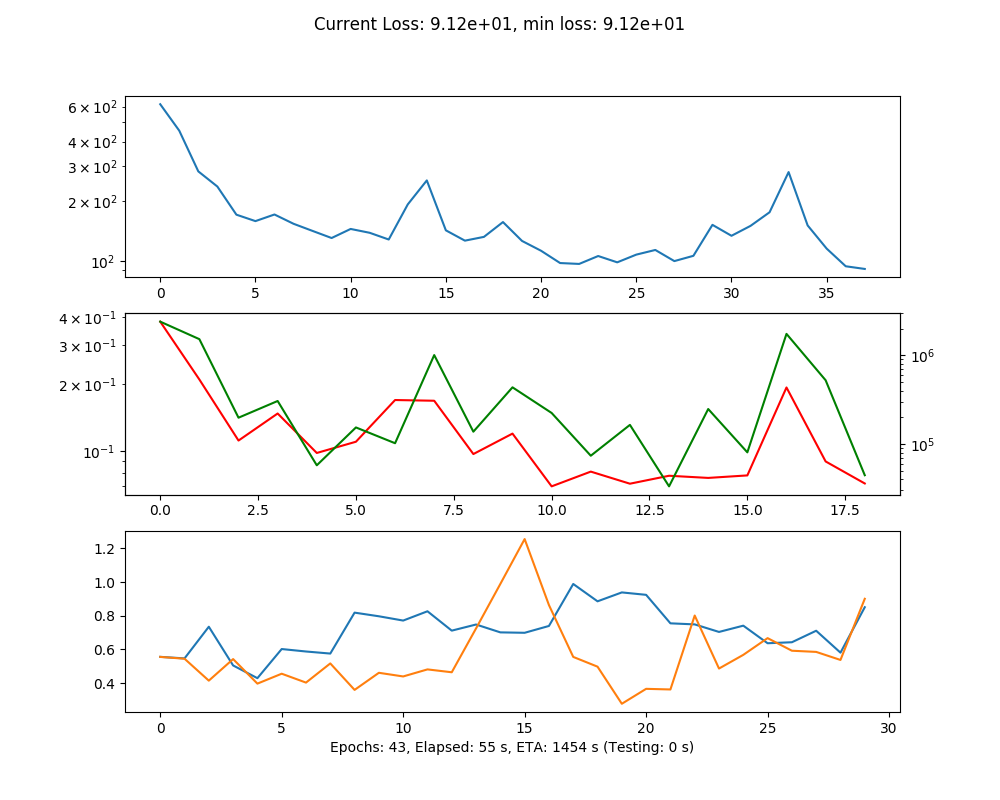

In [ ]:
losses = []
fMse = []
bMse = []
out = None
fig, axis = plt.subplots(3,1, figsize=(10,8))
axis2 = axis[1].twinx()
fig.show()
fig.canvas.draw()
try:
    tStart = time()
    for epoch in range(trainer.numEpochs):

        trainer.scheduler.step()
        
        loss = trainer.train(epoch)
        
        axis[0].clear()
        axis[1].clear()
        axis2.clear()
        axis[2].clear()
        if epoch > 5:
            losses.append(loss)
            fig.suptitle('Current Loss: %.2e, min loss: %.2e' % (loss, np.min(np.abs(losses))))
            axis[0].semilogy(np.arange(len(losses)), np.abs(losses))
            tNow = time()
            elapsed = int(tNow - tStart)
            eta = int((tNow - tStart) / (epoch + 1) * trainer.numEpochs) - elapsed

            if epoch % 2 == 0:
                mses = trainer.test()
                fMse.append(mses[0])
                bMse.append(mses[1])
                out = mses[2]

            axis[1].semilogy(np.arange(len(fMse)), np.abs(fMse), 'r')
            axis2.semilogy(np.arange(len(bMse)), np.abs(bMse), 'g')
            testTime = time() - tNow
            axis[2].plot(out[0, model.outSchema.Halpha].cpu().numpy())
            axis[2].plot(out[0, model.outSchema.Ca8542].cpu().numpy())
            axis[2].set_xlabel('Epochs: %d, Elapsed: %d s, ETA: %d s (Testing: %d s)' % (epoch, elapsed, eta, testTime))
            
            
        fig.canvas.draw()

except KeyboardInterrupt:
    pass
finally:
    print(f"\n\nTraining took {(time()-tStart)/60:.2f} minutes\n")
    totalEpochs += len(losses)


In [ ]:
len(data.testLoader)

In [ ]:
# https://discuss.pytorch.org/t/saving-and-loading-a-model-in-pytorch/2610/4
# model.to('cpu')
save_checkpoint({
    'epoch': totalEpochs,
    'state_dict': model.state_dict(),
    'optimizer': trainer.optim.state_dict(),
    'scheduler': trainer.scheduler.state_dict(),
}, filename='checkpt_07112018_2.pth.tar')

In [ ]:
def save_checkpoint(state, filename='checkpoint.pth.tar'):
    torch.save(state, filename)

In [ ]:
def load_checkpoint(filename):
        if os.path.isfile(filename):
            print("=> loading checkpoint '{}'".format(filename))
            checkpoint = torch.load(filename)
            totalEpochs = checkpoint['epoch']
            model.load_state_dict(checkpoint['state_dict'])
#           trainer.optim.load_state_dict(checkpoint['optimizer'])
#           trainer.scheduler.load_state_dict(checkpoint['scheduler'])
            print("=> loaded checkpoint '{}' (epoch {})"
                  .format(filename, checkpoint['epoch']))
        else:
            print("=> no checkpoint found at '{}'".format(filename))

In [ ]:
model.eval()
with torch.no_grad():
    x, y = next(iter(data.testLoader))
#     xPad = torch.cat((x, torch.zeros(trainer.miniBatchSize, model.totChannels - model.numXChannels, model.channelSize + model.zeroPadding)), dim=1)
#     xPadShape = xPad.shape
#     xPad = torch.reshape(xPad, (trainer.miniBatchSize, -1))
    x = x.to(dev)
    pad_fn = lambda *x: torch.zeros(*x, device=dev)
    inp = model.inSchema.fill({'ne': x[:, 0],
                                'temperature': x[:, 1],
                                'vel': x[:, 2]},
                               zero_pad_fn=pad_fn)
    yz = model(inp.to(dev))
    fig, ax = plt.subplots(1,2)
    ax[0].plot(yz[0, model.outSchema.Halpha].cpu().numpy())
    ax[0].plot(y[0, 0].numpy())
    ax[1].plot(yz[0, model.outSchema.Ca8542].cpu().numpy())
    ax[1].plot(y[0, 1].numpy())

In [ ]:
model.eval()
with torch.no_grad():
    x, y = next(iter(data.testLoader))
    a = max(1.0 / x.shape[0], 0.002)
    y = torch.ones_like(y) * y[0, :, :]
    yz = model.outSchema.fill({'Halpha': y[:, 0], 'Ca8542': y[:, 1], 'LatentSpace': torch.randn})
    xOut = model(yz.to(dev), rev=True)
    fig, ax = plt.subplots(3,2)
    ax[0, 0].plot(yz[0, model.outSchema.Halpha].cpu().numpy())
    ax[0, 1].plot(yz[0, model.outSchema.Ca8542].cpu().numpy())
    for i in range(x.shape[0]):
        ax[1, 0].plot(xOut[i, model.inSchema.ne].cpu().numpy(), c='r', alpha=a)
        ax[1, 1].plot(xOut[i, model.inSchema.temperature].cpu().numpy(), c='r', alpha=a)
        ax[2, 0].plot(xOut[i, model.inSchema.vel].cpu().numpy(), c='r', alpha=a)
    ax[1, 0].plot(x[0, 0].cpu().numpy())
    ax[1, 1].plot(x[0, 1].cpu().numpy())
    ax[2, 0].plot(x[0, 2].cpu().numpy())
    ax[1, 0].set_ylim(5, 20)
    ax[1, 1].set_ylim(2, 8)


In [ ]:
dev

In [ ]:
## Investigate retain_graph!!!

In [ ]:
x, y = next(iter(data.testLoader))
torch.isnan(x[:, 2]).sum()

In [ ]:
a = range(10)

In [ ]:
print(a[-1])
print(a)